In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
FILE_PATH = '/content/drive/MyDrive/CSE710/CSE710 Project/clickbait_data.csv'
data = pd.read_csv(FILE_PATH)
data

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [3]:
text = data['headline'].values
labels = data['clickbait'].values
text_train, text_test, y_train, y_test = train_test_split(text, labels)
print(text_train.shape, text_test.shape, y_train.shape, y_test.shape)

(24000,) (8000,) (24000,) (8000,)


In [4]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [5]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           8320      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
__________________________________________________

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.6625 - accuracy: 0.7821
Epoch 1: val_accuracy improved from -inf to 0.94950, saving model to weights.h5
47/47 [==============================] - 68s 1s/step - loss: 0.6625 - accuracy: 0.7821 - val_loss: 0.4703 - val_accuracy: 0.9495
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.9538
Epoch 2: val_accuracy improved from 0.94950 to 0.96737, saving model to weights.h5
47/47 [==============================] - 64s 1s/step - loss: 0.3331 - accuracy: 0.9538 - val_loss: 0.2239 - val_accuracy: 0.9674
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9720
Epoch 3: val_accuracy improved from 0.96737 to 0.97237, saving model to weights.h5
47/47 [==============================] - 66s 1s/step - loss: 0.1611 - accuracy: 0.9720 - val_loss: 0.1165 - val_accuracy: 0.9724
Epoch 4/20
47/47 [==============================] - ETA: 0s - loss: 0.0928 - accuracy

In [8]:
model.load_weights('weights.h5')
model.save('model')

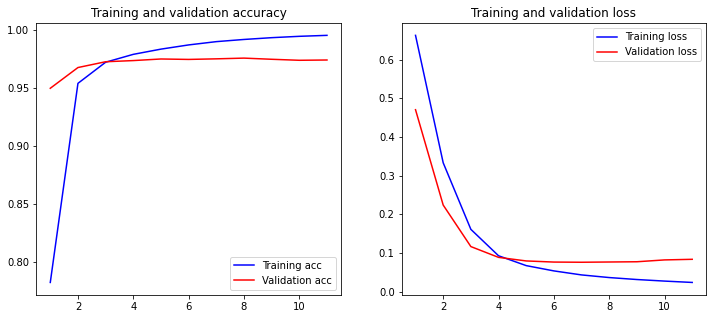

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

250/250 [==============================] - 12s 45ms/step


<Figure size 432x288 with 0 Axes>

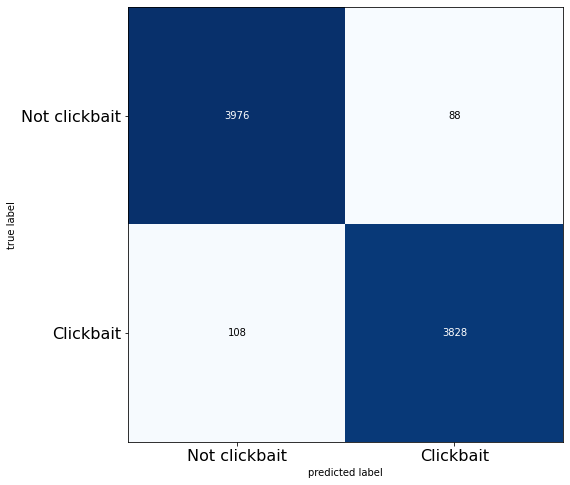

In [10]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

In [11]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.98


In [12]:
test = ['The Biggest in Football History!', 'Learning game development with Unity', 'A tour of Japan\'s Kansai region', '12 things NOT to do in Europe']
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=maxlen)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

1/1 [==============================] - 0s 447ms/step
The Biggest in Football History! - Clickbait
Learning game development with Unity - Not Clickbait
A tour of Japan's Kansai region - Not Clickbait
12 things NOT to do in Europe - Clickbait
